In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle

import os
import re
from collections import OrderedDict

import seaborn as sns
sns.set_theme(font_scale=1.5);

In [4]:
Earray   = np.round(np.logspace(np.log10(0.250), np.log10(10000), 100), 2)
h        = np.linspace(0, 499, 500);
binWidth = np.hstack([np.diff(Earray), np.diff(Earray)[-1]]);

def ProcessIoniData(data):
    
    lineNo = 1000
    
    nRuns  = int(len(data)/lineNo)
    
    mean = np.zeros([1000])
    std  = np.zeros([1000])
    for i in range(0, nRuns):
        
        mean += data.E.values[i*lineNo:(i+1)*lineNo]
        
        std  += (data.E.values[i*lineNo:(i+1)*lineNo])**2
        
    std -= (mean/nRuns)**2
    
    std[std < 0] = 0
    
    std = np.sqrt(1/(nRuns-1) * std)
    
    return mean, std

def ProcessSpectralData(data):
    
    lineNo = 1000
    
    nRuns  = int(len(data)/lineNo)
    
    data.fillna(data.mean(), inplace=True)

    mean = np.zeros([lineNo, 100]);
    std  = np.zeros([lineNo, 100]);
    for i in range(0, nRuns):
        mean += data.values[lineNo*i:lineNo*(i+1), :]
        std  += (data.values[lineNo*i:lineNo*(i+1), :])**2
        
    std -= (mean/nRuns)**2
    
    std[std < 0] = 0
    
    std = np.sqrt(1/(nRuns-1) * std)
    
    return mean/binWidth, std/binWidth

From sin(a$\alpha$) from $\alpha \in [0, 45^\circ]$,

$$N_{n=1} = 2 \pi \int_{0}^{45^\circ} sin^2(\alpha)~ d\alpha = 0.89660$$

$$\frac{1}{2\pi N_n} \frac{d^3 N}{dt ~dA ~d\Omega} = f_0 \rightarrow \frac{N}{2\pi N_n} = f_0$$

In [3]:
normFactor = 1e4

In [9]:
def build_table(path, energyDist):

    files = os.listdir(path)
    
    D = OrderedDict()
    
    files = [f for f in files if energyDist in f]
    
    for file in files:
        tmp = file.split('_')
        
        particle = tmp[0]
        fileType = tmp[1]
        E = int(re.findall(r'\d+', file)[0])
        PAD_ang = int(re.findall(r'\d+', tmp[-2].split('.')[0])[0])
        


        if fileType == "ene":
            fileType = "spectra"
            readIn = pd.read_csv(path + file, names=Earray)
            mean, std = np.divide(ProcessSpectralData(readIn), normFactor)
            
            mean = mean[:500, :]
            std  = std[:500, :]

        elif fileType == "dep":
            fileType = "ioni"
            readIn = pd.read_csv(path + file, names=['E'])
            mean, std = np.divide(ProcessIoniData(readIn), normFactor)
            mean = mean[:500]
            std  = std[:500]

        D[(particle, fileType, E, PAD_ang)] = (mean, std)
        
    return D

D_mono = build_table("../data/PADruns_test3/", "mono")

In [8]:
filename = "G4data_mono_discretePAD.pkl"

with open(filename, 'wb') as f:
    pickle.dump(D_mono, f, protocol=pickle.HIGHEST_PROTOCOL)

D_mono = pickle.load(open(filename, 'rb'))
   
'''
filename = "G4data_sin45_exp.pkl"

with open(filename, 'wb') as f:
    pickle.dump(D_exp, f, protocol=pickle.HIGHEST_PROTOCOL)
    
D_exp = pickle.load(open(filename, 'rb'))

    
!cp G4data_sin45_mono.pkl G4data_sin45_exp.pkl ../../G4EPP-git/G4EPP/data/
''';

'''
# Test
del D
    
with open(filename, 'rb') as f:
    D = pickle.load(f)
''';

0 deg ~ 0.099 keV/part
5 deg ~ 0.197 keV/part
10 deg ~ 0.295 keV/part
15 deg ~ 0.394 keV/part
20 deg ~ 0.492 keV/part
25 deg ~ 0.589 keV/part
30 deg ~ 0.686 keV/part
35 deg ~ 0.783 keV/part
40 deg ~ 0.878 keV/part
45 deg ~ 0.973 keV/part
50 deg ~ 1.065 keV/part
55 deg ~ 1.155 keV/part
60 deg ~ 1.242 keV/part
65 deg ~ 1.325 keV/part
70 deg ~ 1.401 keV/part


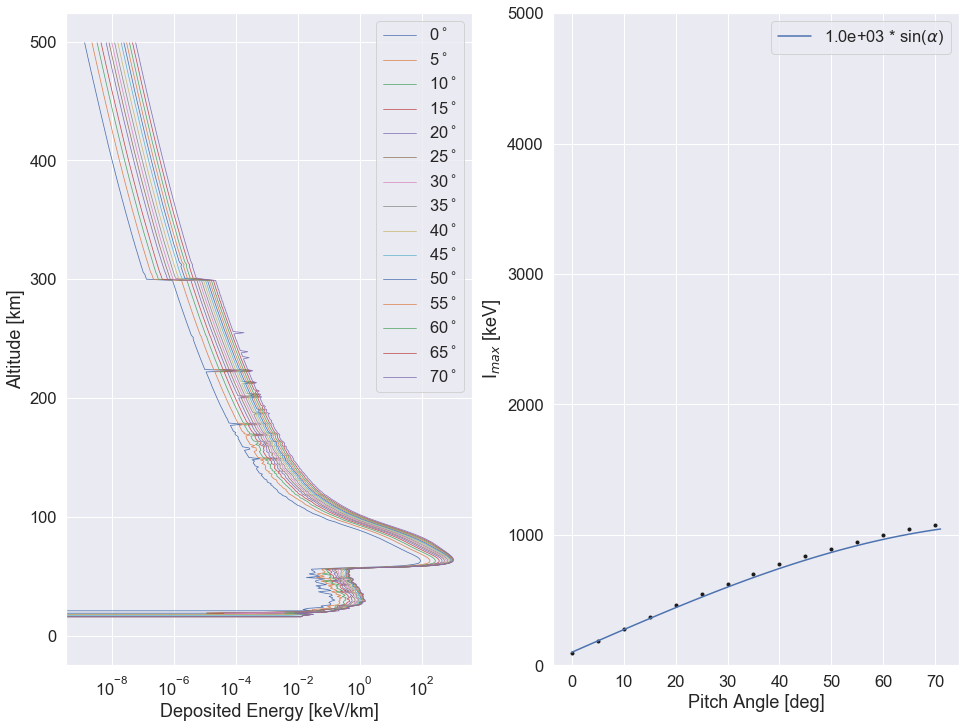

In [11]:
from scipy.signal import savgol_filter

energy = 1000


plt.figure(figsize=(16,12)); plt.subplot(1,2,1); plt.grid(True, which='both')
#for i in [0, 70]:
for i in range(0, 75, 5):
    if i % 5 == 0:
        label = '%.0f$^\circ$' % i
    else: 
        label = None
    plt.semilogx(D_mono[('electron', 'ioni', energy, i)][0], h, 
                 label=label, linewidth=0.75)
    
    print("%.0f deg ~ %.3f keV/part" % (i, np.sum(D_mono[('electron', 'ioni', energy, i)][0])/1e4))


plt.legend();
#plt.yscale('log')
#plt.ylim([1e1, 300]);
#plt.xlim([1e-6, 1e4]);
plt.ylabel('Altitude [km]');
plt.xlabel('Deposited Energy [keV/km]');

plt.subplot(1,2,2); plt.grid(True, which='both');

for i in range(0,75,5):
    plt.plot(i, np.max(D_mono[('electron', 'ioni', energy, i)][0]), 'k.')
        
    
coef = 1e3
plt.plot(range(0, 72), 100+coef*np.sin(np.deg2rad(range(0, 72))), label=r'%.1e * sin($\alpha$)' % coef)
plt.ylabel('I$_{max}$ [keV]');
plt.xlabel('Pitch Angle [deg]');
plt.legend();

plt.ylim(0, 5000);
#plt.yscale('log');
#plt.xscale('log');

0 deg ~ 0.000 keV/part
5 deg ~ 0.000 keV/part
10 deg ~ 0.000 keV/part
15 deg ~ 0.000 keV/part
20 deg ~ 0.000 keV/part
25 deg ~ 0.000 keV/part
30 deg ~ 0.000 keV/part
35 deg ~ 0.000 keV/part
40 deg ~ 0.000 keV/part
45 deg ~ 0.000 keV/part
50 deg ~ 0.000 keV/part
55 deg ~ 0.000 keV/part
60 deg ~ 0.000 keV/part
65 deg ~ 0.000 keV/part
70 deg ~ 0.000 keV/part


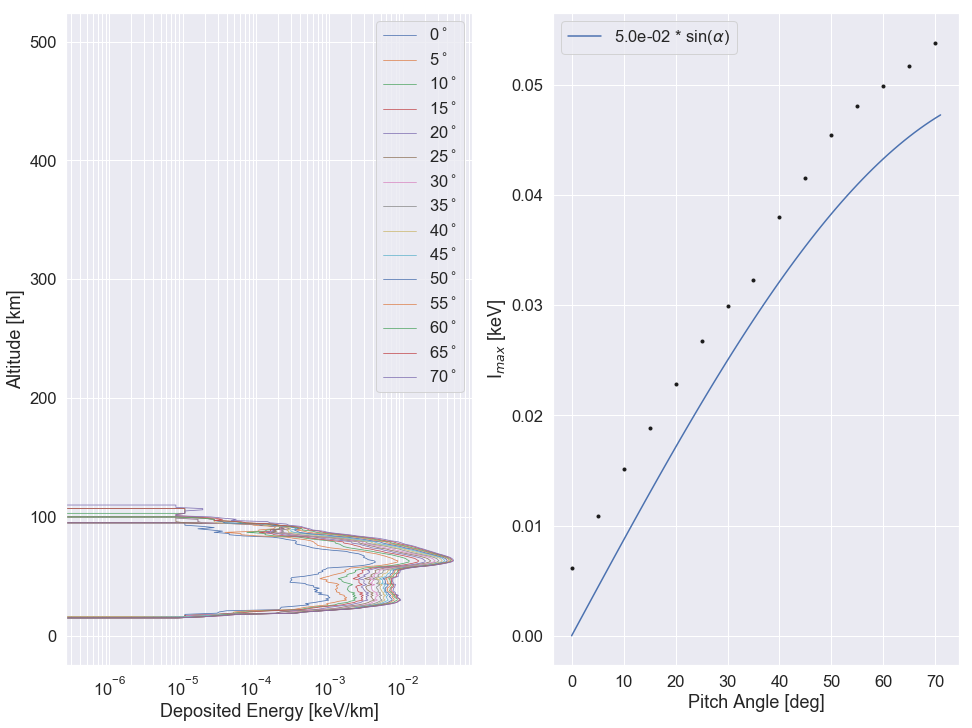

In [8]:
from scipy.signal import savgol_filter

energy = 1000


plt.figure(figsize=(16,12)); plt.subplot(1,2,1); plt.grid(True, which='both')
#for i in [0, 70]:
for i in range(0, 75, 5):
    if i % 5 == 0:
        label = '%.0f$^\circ$' % i
    else: 
        label = None
    plt.semilogx(savgol_filter(D_mono[('photon', 'ioni', energy, i)][0], 5, 0), h, 
                 label=label, linewidth=0.75)
    
    print("%.0f deg ~ %.3f keV/part" % (i, np.sum(D_mono[('photon', 'ioni', energy, i)][0])/1e4))


plt.legend();
#plt.yscale('log')
#plt.ylim([1e1, 300]);
#plt.xlim([1e-6, 1e4]);
plt.ylabel('Altitude [km]');
plt.xlabel('Deposited Energy [keV/km]');

plt.subplot(1,2,2); plt.grid(True, which='both');

for i in range(0,75,5):
    plt.plot(i, np.max(D_mono[('photon', 'ioni', energy, i)][0]), 'k.')
        
    
coef = 0.5e-1
plt.plot(range(0, 72), coef*np.sin(np.deg2rad(range(0, 72))), label=r'%.1e * sin($\alpha$)' % coef)
plt.ylabel('I$_{max}$ [keV]');
plt.xlabel('Pitch Angle [deg]');
plt.legend();

#plt.ylim(0, 5000);
#plt.yscale('log');
#plt.xscale('log');

0 deg ~ 0.000 keV/part
5 deg ~ 0.000 keV/part
10 deg ~ 0.000 keV/part
15 deg ~ 0.000 keV/part
20 deg ~ 0.000 keV/part
25 deg ~ 0.000 keV/part
30 deg ~ 0.000 keV/part
35 deg ~ 0.000 keV/part
40 deg ~ 0.000 keV/part
45 deg ~ 0.000 keV/part
50 deg ~ 0.000 keV/part
55 deg ~ 0.000 keV/part
60 deg ~ 0.000 keV/part
65 deg ~ 0.000 keV/part
70 deg ~ 0.000 keV/part


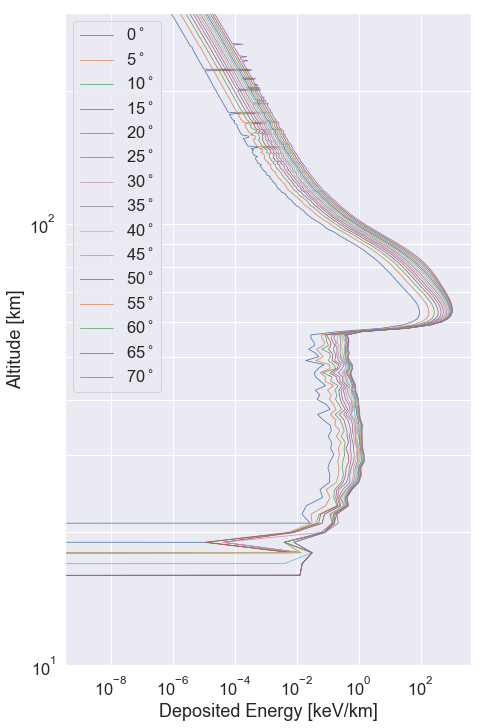

In [39]:
from scipy.signal import savgol_filter

energy = 1000


plt.figure(figsize=(16,12)); plt.subplot(1,2,1); plt.grid(True, which='both')
#for i in [0, 70]:
for i in range(0, 75, 5):
    if i % 5 == 0:
        label = '%.0f$^\circ$' % i
    else: 
        label = None
    plt.semilogx(savgol_filter(D_mono[('photon', 'ioni', energy, i)][0] +
                               D_mono[('electron', 'ioni', energy, i)][0], 1, 0), h, 
                 label=label, linewidth=0.75)
    
    print("%.0f deg ~ %.3f keV/part" % (i, np.sum(D_mono[('photon', 'ioni', energy, i)][0])/1e4))


plt.legend();
plt.yscale('log')
plt.ylim(1e1, 300)
#plt.yscale('log')
#plt.ylim([1e1, 300]);
#plt.xlim([1e-6, 1e4]);
plt.ylabel('Altitude [km]');
plt.xlabel('Deposited Energy [keV/km]');

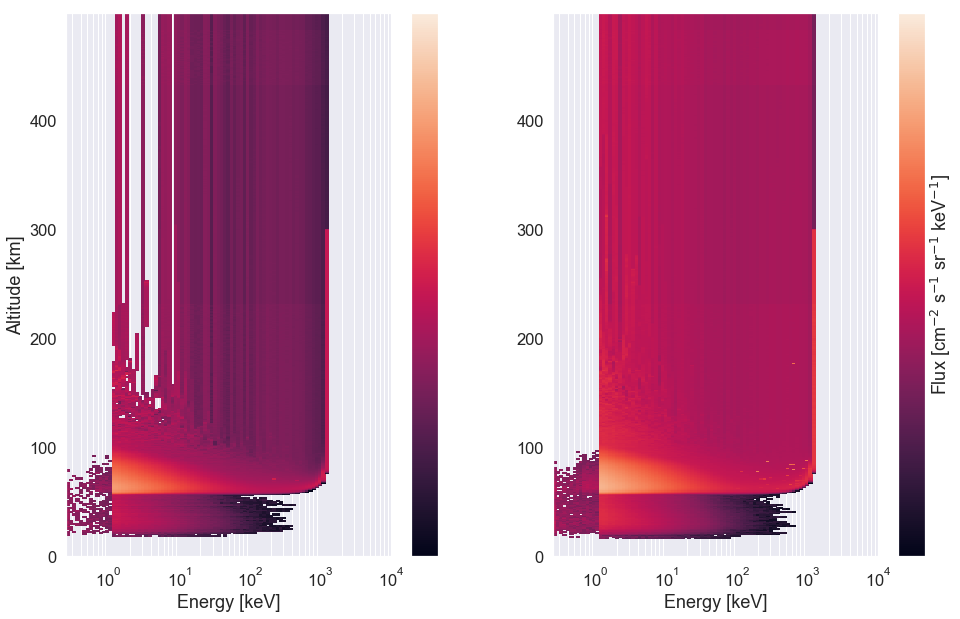

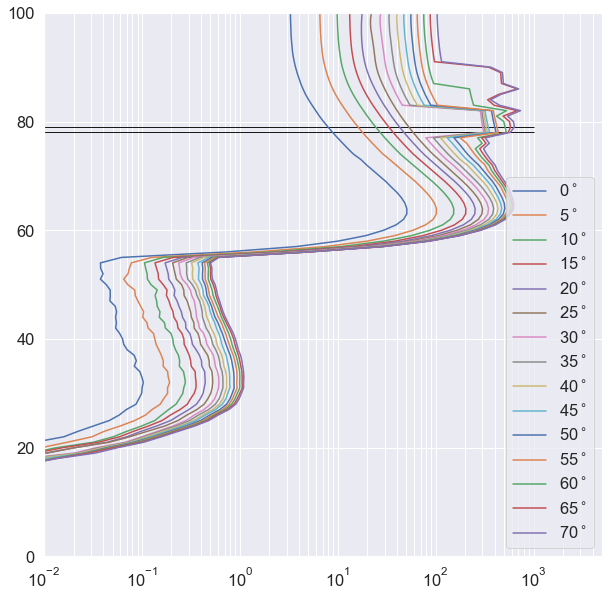

In [65]:
from matplotlib.colors import LogNorm

X,Y = np.meshgrid(Earray, h);


plt.figure(figsize=(16,10)); 
plt.subplot(1,2,1); plt.grid(True, which='both')
plt.pcolormesh(X, Y, D_mono[('electron', 'spectra', 1000, 10)][0], 
               norm=LogNorm(), vmin=1e-6, vmax=1e4);
plt.colorbar();
plt.xscale('log');
plt.xlabel('Energy [keV]');
plt.ylabel('Altitude [km]');

plt.subplot(1,2,2); plt.grid(True, which='both')
plt.pcolormesh(X, Y, D_mono[('electron', 'spectra', 1000, 70)][0], 
               norm=LogNorm(), vmin=1e-6, vmax=1e4);
plt.colorbar(label='Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ keV$^{-1}$]');
plt.xscale('log');
plt.xlabel('Energy [keV]');

plt.figure(figsize=(10,10)); plt.grid(True, which='both')
for i in range(0, 72, 5):
    plt.plot(savgol_filter(np.trapz(D_mono[('electron', 'spectra', 1000, i)][0], x=Earray), 5, 1), 
             h, label='%.0f$^\circ$' % i)

plt.hlines(79, 1e-2, 1e3, linewidth=1)

plt.hlines(78, 1e-2, 1e3, linewidth=1)
plt.xscale('log');
plt.ylim(0, 300);
plt.ylim(0, 100)
plt.xlim(1e-2, 5e3);
plt.legend();